Install faiss

In [ ]:
%pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.4 MB/s eta 0:00:00


Download and extract SIFT1M

In [ ]:
!wget ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz

--2023-09-21 06:07:50--  ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
           => ‘sift.tar.gz’
Resolving ftp.irisa.fr (ftp.irisa.fr)... 131.254.254.45, 2001:660:7303:254::45
Connecting to ftp.irisa.fr (ftp.irisa.fr)|131.254.254.45|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /local/texmex/corpus ... done.
==> SIZE sift.tar.gz ... 168280445
==> PASV ... done.    ==> RETR sift.tar.gz ... done.
Length: 168280445 (160M) (unauthoritative)

sift.tar.gz         100%[===================>] 160.48M  12.6MB/s    in 15s     

2023-09-21 06:08:08 (11.0 MB/s) - ‘sift.tar.gz’ saved [168280445]



In [ ]:
!tar -xvzf sift.tar.gz

sift/
sift/sift_base.fvecs
sift/sift_groundtruth.ivecs
sift/sift_learn.fvecs
sift/sift_query.fvecs


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    print(a.shape,d)
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples
wb = read_fvecs('sift/sift_base.fvecs')
# queries
xq = read_fvecs('sift/sift_query.fvecs')

(129000000,) 128
(1290000,) 128


In [ ]:
wb.shape

(1000000, 128)

In [ ]:
import faiss

d = wb.shape[1]
nbits = 4

# initialize the index using our vectors dimensionality (128) and nbits
index = faiss.IndexLSH(d, nbits)
# then add the data
index.add(wb)

In [ ]:
xq0 = xq[0].reshape(1, d)
# we use the search method to find the k nearest vectors
D, I = index.search(xq0, k=10)
# the indexes of these vectors are returned to I
I

array([[26, 47, 43,  2,  6, 70, 73, 74, 25,  0]])

In [ ]:
# we can retrieve the original vectors from wb using these indexes
wb[I[0]]

array([[31., 15., 47., ...,  0.,  1., 19.],
       [ 0.,  0.,  0., ...,  0., 30., 72.],
       [22., 15., 43., ...,  0.,  0., 12.],
       ...,
       [ 6., 15.,  9., ..., 12., 17., 21.],
       [33., 22.,  8., ...,  0., 11., 69.],
       [ 0., 16., 35., ..., 25., 23.,  1.]], dtype=float32)

In [ ]:
# and calculate the cosine similarity between each of these vectors and xq[0]
cosine_similarity(wb[I[0]], [xq[0]])

array([[0.7344476 ],
       [0.6316513 ],
       [0.6995599 ],
       [0.20448917],
       [0.3054034 ],
       [0.25432232],
       [0.3049795 ],
       [0.34137404],
       [0.69142616],
       [0.2670474 ]], dtype=float32)

Why is the index performing so poorly? Well, we already know why. All of these vectors are stored in the LSH index under the same 4-digit, low resolution hash. We can confirm this by checking the other variable returned from our search, `D` - the *distances* calculated by our LSH index.

In [ ]:
D

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

A perfect *zero* for every single item. We know that the *Hamming distance* can only be **0** for perfect matches. So, there is only one hash bucket that will score **0**. This means that we can check how many of our vectors have been stored within this single LSH bucket by finding the point that the Hamming distance reaches 1? Let's search again, this time increasing `k` until we return a `D` array that contains more than just *zeros*.

In [ ]:
k = 100
xq0 = xq[0].reshape(1, d)

while True:
    D, I = index.search(xq0, k=k)
    if D.any() != 0:
        print(k)
        break
    k += 100

172100


In [ ]:
D  # we will see both 0s, and 1s

array([[0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
D[:, 172_039:172_041]  # we see the hash code switch at position 172_039

array([[0., 1.]], dtype=float32)

What `nbits` value gives us a better chance for a more sparse distribution of our vectors?

In [ ]:
for nbits in [2, 4, 8, 16, 24, 32]:
    buckets = 1 << nbits
    print(f"nbits == {nbits}")
    print(f"{wb.shape[0]} / {buckets} = {wb.shape[0]/buckets}")

nbits == 2
1000000 / 4 = 250000.0
nbits == 4
1000000 / 16 = 62500.0
nbits == 8
1000000 / 256 = 3906.25
nbits == 16
1000000 / 65536 = 15.2587890625
nbits == 24
1000000 / 16777216 = 0.059604644775390625
nbits == 32
1000000 / 4294967296 = 0.00023283064365386963


In [ ]:
xq0 = xq[0].reshape(1, d)
k = 100

for nbits in [2, 4, 8, 16, 24, 32]:
    index = faiss.IndexLSH(d, nbits)
    index.add(wb)
    D, I = index.search(xq0, k=k)
    cos = cosine_similarity(wb[I[0]], xq0)
    print(np.mean(cos))
    print(I)

0.5424448
[[ 38  73 145 122 217  81 154 148  22 123 109  95 219  74 193  58 156  43
  153  26 132  18 129  10 113  35 233 232  87 225 197 194  70 215 176 174
  159 169 149  49  39 190  29 133  25 140 124 126  16 143 114 118   8 120
  102 107   2  93 237  96 238 222 224 218 239 201 202  76 210  99 191  68
  240 184 186 172 187 167 168 155 188  47 151  45 152  41 146  37 242 136
  137  27 139 131 243 144 121 108   6   0]]
0.560827
[[120  73 242 108 421 392 124 286 113 184 102 132 424  74 398 123 320  43
  316  26 194 107 190 153 152 140 131 440  87 435 406 403  70 420 363 353
  326 336 303 302 270 389 215 201  25 224 186 188 114 232 154 155 146 172
   99 144   2 444 451 438 461  96 427 423 464 409 412 399 418 394 396  81
  469 372 376 348 381 330 332 317 385  47 311 300 314 283 284 239 470 217
  218 197 222 193 474 237 176 145   6   0]]
0.6372647
[[2002  275 2004  495  261 3172  228 2111   34 1448 1141 3812 3591 3385
  3230 3005 2837 2278 2699  300 1556 1479 1523 1199 1163 1049 3895 3864

In [ ]:
xq0 = xq[0].reshape(1, d)
k = 100

results = pd.DataFrame({
    'nbits': [],
    'cosine_sim': []
})

for epoch in range(1):
    print('.', end='')
    for nbits in [2, 4, 8, 16, 24, 32, 64, 128]:
        index = faiss.IndexLSH(d, nbits)
        index.add(wb)
        D, I = index.search(xq0, k=k)
        cos = cosine_similarity(wb[I[0]], xq0)
        df = pd.DataFrame({
            'cosine_sim': cos.reshape(cos.shape[0])
        })
        df['nbits'] = nbits
        results = results.append(df, ignore_index=True)
        print(results)

.

<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


    nbits  cosine_sim
0     2.0    0.512804
1     2.0    0.304980
2     2.0    0.759479
3     2.0    0.703182
4     2.0    0.748983
..    ...         ...
95    2.0    0.713985
96    2.0    0.782912
97    2.0    0.703823
98    2.0    0.305403
99    2.0    0.267047

[100 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
195    4.0    0.253997
196    4.0    0.587719
197    4.0    0.759479
198    4.0    0.305403
199    4.0    0.267047

[200 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
295    8.0    0.607052
296    8.0    0.543088
297    8.0    0.542245
298    8.0    0.742501
299    8.0    0.775864

[300 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
395   16.0    0.774077
396   16.0    0.723255
397   16.0    0.595360
398   16.0    0.651265
399   16.0    0.590400

[400 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
495   24.0    0.804595
496   24.0    0.689325
497   24.0    0.795420
498   24.0    0.749529
499   24.0    0.771300

[500 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
595   32.0    0.714064
596   32.0    0.725134
597   32.0    0.715338
598   32.0    0.785418
599   32.0    0.651885

[600 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
695   64.0    0.699056
696   64.0    0.730568
697   64.0    0.772627
698   64.0    0.787968
699   64.0    0.835675

[700 rows x 2 columns]
     nbits  cosine_sim
0      2.0    0.512804
1      2.0    0.304980
2      2.0    0.759479
3      2.0    0.703182
4      2.0    0.748983
..     ...         ...
795  128.0    0.761732
796  128.0    0.838652
797  128.0    0.743713
798  128.0    0.840567
799  128.0    0.809508

[800 rows x 2 columns]


<ipython-input-16-6ce6be1eabfc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df, ignore_index=True)


<Axes: xlabel='nbits', ylabel='cosine_sim'>

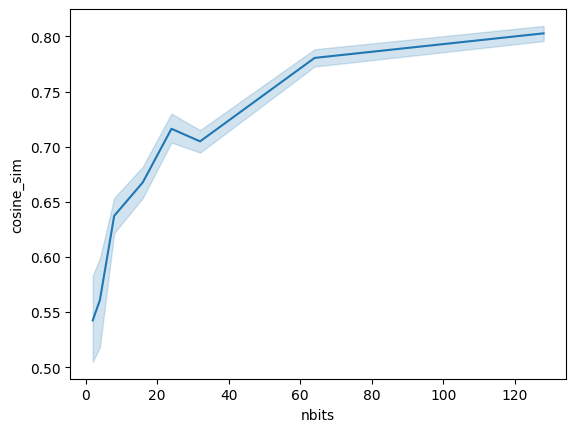

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=results, x='nbits', y='cosine_sim')

## Assessing Issues

We can also extract the vectors from our index, first let's initialize a new index with `nbits == 4`

In [ ]:
nbits = 4
index = faiss.IndexLSH(d, nbits)
index.add(wb)

And extract the actual binary vectors stored inside our LSH index like so.

In [ ]:
# extract index binary codes (represented as int)
arr = faiss.vector_to_array(index.codes)
arr

array([ 5, 12,  5, ..., 15, 13, 12], dtype=uint8)

In [ ]:
# we see that there are 1M of these values, 1 for each vector
arr.shape

(1000000,)

We can convert these into our binary vector format like so:

In [ ]:
bin_vecs = (((arr[:, None] & (1 << np.arange(nbits)))) > 0).astype(int)
bin_vecs

array([[1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 1, 0],
       ...,
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 1, 1]])

And convert them into strings for bucketing too:

In [ ]:
dist_arr = np.apply_along_axis(lambda x: ''.join(x), 1, bin_vecs.astype(str))

In [ ]:
order_bins = ['0'* (6-len(bin(x))) + bin(x)[2:] for x in range(16)]
order_bins

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

Okay we can see that there are definitely far too many items in each bucket - remember that we cannot differentiate vectors that have been placed into the same bucket, so we can tell from this that our `nbits` value *must* be increased.

## Visualizing Performance

Now, let's take a look at *which* `nbits` values produce the best performance and speed.

In [ ]:
from datetime import datetime

k = 50

# initialize results dataframe
results = pd.DataFrame({
    'search_time': [],
    'recall': [],
    'nbits': [],
    'nb': []
})

for epoch in range(1):
    print('.', end='')
    # number of samples to index
    for nb in [50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000]:
        # exhaustive search results
        index = faiss.IndexFlatL2(d)
        index.add(wb[:nb])
        start = datetime.now()
        D, I = index.search(xq0, k)
        flat_time = (datetime.now() - start).microseconds
        target_ids = I[0].tolist()
        # LSH search
        for nbits in [64, 128, 256, 512, 768, 32]:

            #Question1: Write script to create index using the data and corresponding nbits.
            index = faiss.IndexLSH(d, nbits)
            index.add(wb[:nb])
            start = datetime.now() #Should only time the search
            D, I = index.search(xq0, k=k)
            lsh_time = (datetime.now() - start).microseconds

            #Question2: Considering target_ids as the ground truth, calculqte recall values of LSH output you obtained in Question1.
            recall = len( [id for id in I[0].tolist() if id in target_ids] )/k

            results = results.append(
                pd.DataFrame({
                    'search_time': [lsh_time / flat_time],
                    'recall': [recall],
                    'nbits': [nbits],
                    'nb': [nb]
                }), ignore_index=True
            )

.

<ipython-input-24-d686d0d5d1cd>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
<ipython-input-24-d686d0d5d1cd>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
<ipython-input-24-d686d0d5d1cd>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
<ipython-input-24-d686d0d5d1cd>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
<ipython-input-24-d686d0d5d1cd>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
<ipython-input-

<Axes: xlabel='nb', ylabel='recall'>

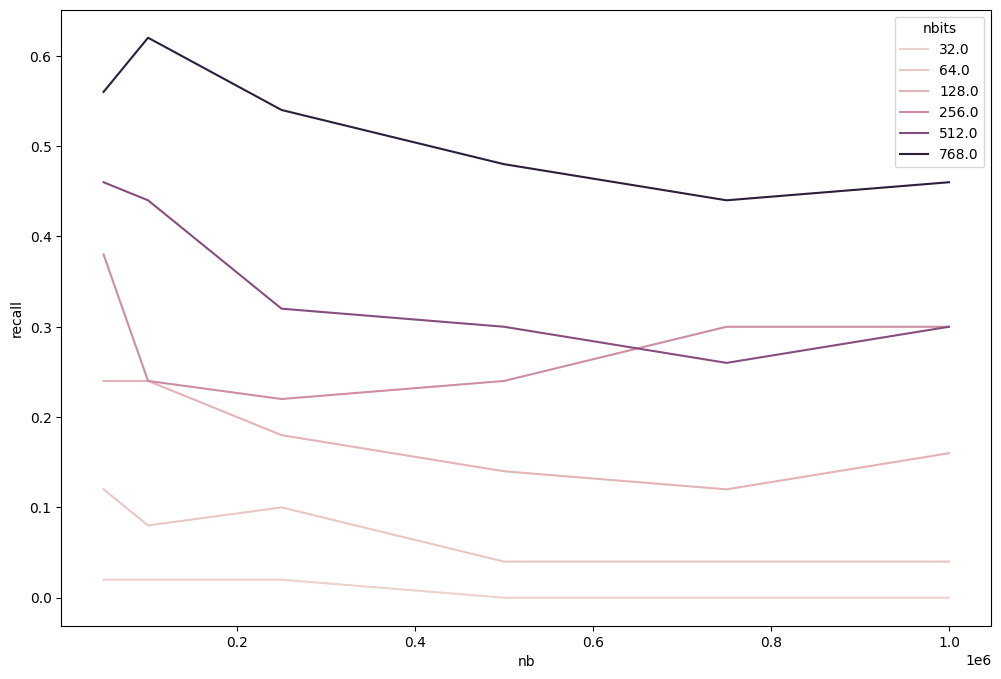

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='recall', hue='nbits')

We certainly need to be pushing our `nbits` values high to get reasonable recall values, but we also risk making our search slower than an *exhaustive* search - so there is a bit of balancing required to find the sweet spot for each use-case.

Question3: For every nbits, plot nb (X-axis) vs search time (Y-axis).

<Axes: xlabel='nb', ylabel='search_time'>

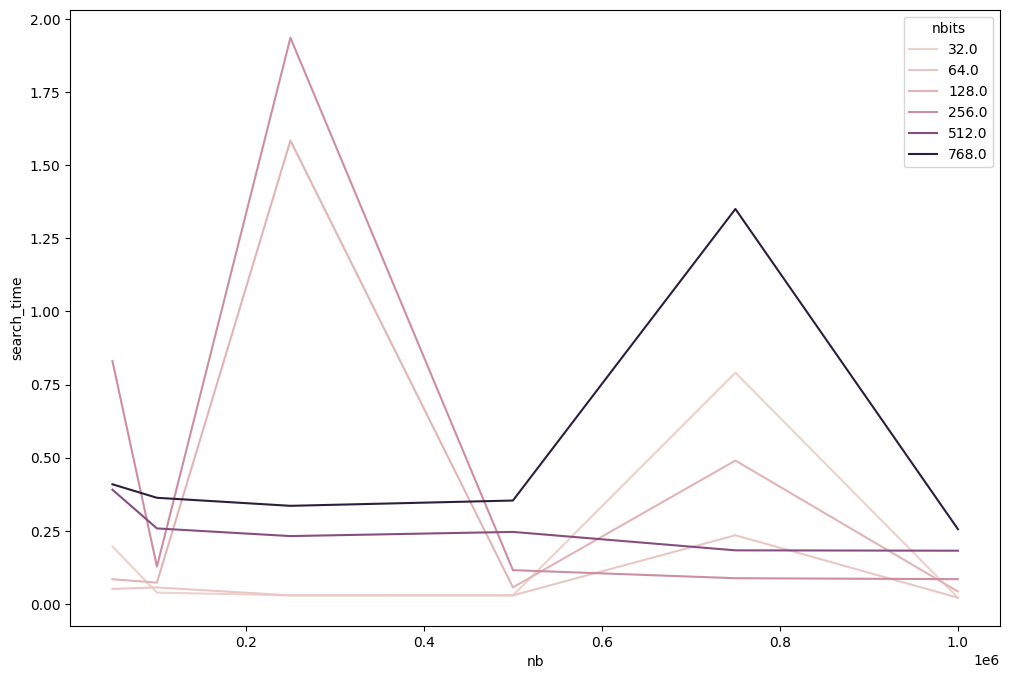

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='search_time', hue='nbits')

Question4: How would you find the optimal nbits for your data?

I would choose 512 nbits for this data. It consistently had a recall higher than 0.3, except for the case of 750000 samples to index. This recall value was higher than almost all the other nbit values on average, with the only exception being 768 nbits. However, I would still prefer 512 nbits as its search time is consistently lower than for 768 nbits.